In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import L1, L2
from keras.initializers import RandomUniform

In [2]:
# load the dataset
from utils import read_cup
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
# Let's take also a validation set to use earlystopping
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [3]:
# Define metric MEE

import keras.backend as K

def MEE_keras(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# First try

In [4]:
nn = Sequential()
nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=L2(1e-8)))
nn.add(Dense(64, activation='relu', kernel_regularizer=L2(1e-8)))
nn.add(Dense(3, activation='linear', kernel_regularizer=L2(1e-8)))

nn.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9, nesterov=True), loss='MSE', metrics=MEE_keras)

history = nn.fit(X_train, y_train, epochs=1000, batch_size=1)

Epoch 1/1000
800/800 [==============================] - 0s 267us/step - loss: 79.3659 - MEE_keras: 9.7114
Epoch 2/1000
800/800 [==============================] - 0s 256us/step - loss: 5.8605 - MEE_keras: 3.5633
Epoch 3/1000
800/800 [==============================] - 0s 252us/step - loss: 3.9456 - MEE_keras: 2.8934
Epoch 4/1000
800/800 [==============================] - 0s 258us/step - loss: 3.3541 - MEE_keras: 2.7136
Epoch 5/1000
800/800 [==============================] - 0s 255us/step - loss: 2.7126 - MEE_keras: 2.4480
Epoch 6/1000
800/800 [==============================] - 0s 254us/step - loss: 2.4936 - MEE_keras: 2.3734
Epoch 7/1000
800/800 [==============================] - 0s 257us/step - loss: 2.1366 - MEE_keras: 2.1757
Epoch 8/1000
800/800 [==============================] - 0s 251us/step - loss: 1.9409 - MEE_keras: 2.0721
Epoch 9/1000
800/800 [==============================] - 0s 257us/step - loss: 1.7614 - MEE_keras: 1.9923
Epoch 10/1000
800/800 [==============================]

In [13]:
history.history.keys()

dict_keys(['loss', 'MEE_keras'])

7/7 [==============================] - 0s 666us/step - loss: 0.2554 - MEE_keras: 0.6627
Test Loss: 0.2554
Test MEE: 0.6627


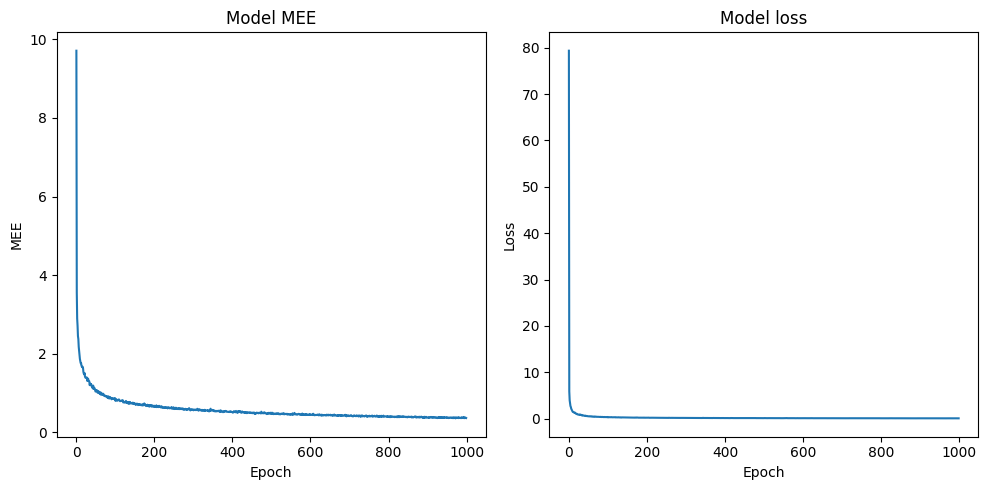

In [8]:
# test loss and mee
loss, MEE_keras = nn.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test MEE: {MEE_keras:.4f}')

history = history.history

# plot training mee values
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history['MEE_keras'])
plt.title('Model MEE')
plt.ylabel('MEE')
plt.xlabel('Epoch')

# plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

# Let's do things better

In [4]:
# weight initializer
initializer = RandomUniform(minval=-0.5, maxval=0.5, seed=6)

In [7]:
model = Sequential()
model.add(
    Dense(
        units=64, 
        input_dim=X_train.shape[1], 
        activation='relu', 
        kernel_regularizer=L2(1e-6), 
        kernel_initializer=initializer
    )
)
model.add(
    Dense(
        units=64, 
        activation='relu', 
        kernel_regularizer=L2(1e-6), 
        kernel_initializer=initializer
    )
)
model.add(
    Dense(
        units=3, 
        activation='linear', 
        kernel_regularizer=L2(1e-6), 
        kernel_initializer=initializer
    )
)

model.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True), 
    loss='MSE', 
    metrics=MEE_keras)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.01,
    patience=100, 
    restore_best_weights=True
)
history = model.fit(
    X_train, 
    y_train, 
    epochs=3000, 
    batch_size=1, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/3000
640/640 [==============================] - 0s 394us/step - loss: 42.5669 - MEE_keras: 6.8892 - val_loss: 7.7147 - val_MEE_keras: 4.1373
Epoch 2/3000
640/640 [==============================] - 0s 313us/step - loss: 4.3361 - MEE_keras: 3.1422 - val_loss: 3.5635 - val_MEE_keras: 2.8826
Epoch 3/3000
640/640 [==============================] - 0s 312us/step - loss: 2.9666 - MEE_keras: 2.5852 - val_loss: 2.8194 - val_MEE_keras: 2.5884
Epoch 4/3000
640/640 [==============================] - 0s 311us/step - loss: 2.4243 - MEE_keras: 2.3453 - val_loss: 2.7669 - val_MEE_keras: 2.3673
Epoch 5/3000
640/640 [==============================] - 0s 314us/step - loss: 2.0987 - MEE_keras: 2.1776 - val_loss: 1.6141 - val_MEE_keras: 1.8461
Epoch 6/3000
640/640 [==============================] - 0s 314us/step - loss: 1.8687 - MEE_keras: 2.0435 - val_loss: 2.1917 - val_MEE_keras: 2.2118
Epoch 7/3000
640/640 [==============================] - 0s 312us/step - loss: 1.5511 - MEE_keras: 1.8810 - val_

7/7 [==============================] - 0s 632us/step - loss: 0.4252 - MEE_keras: 0.8402
Test Loss: 0.4252
Test MEE: 0.8402


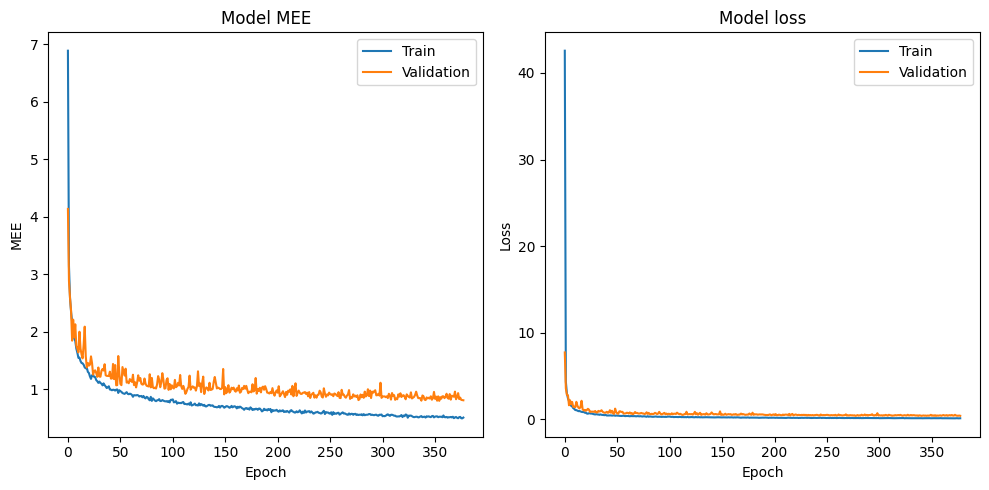

In [8]:
# test loss and mee
loss, MEE_keras = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test MEE: {MEE_keras:.4f}')

history = history.history

# plot training and validation mee values
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history['MEE_keras'])
plt.plot(history['val_MEE_keras'])
plt.title('Model MEE')
plt.ylabel('MEE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# TODO: investigate about the weight initialization !!! Because with fan-in things were better... BUT apparently keras doesn't have fan-in... uff -.-' try GLOROT?!?